In [8]:
import os
import pickle
import numpy as np
import datetime
import json
from multiprocessing import Process
from multiprocess import Process

import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16, MobileNetV2, MobileNetV3Small

from models import *
from utils import regression_stats
#from img_utils import data_to_df, preprocess_images, set_gpu, set_cpu

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2

In [9]:
from utils import data_to_df, preprocess_images, set_gpu, set_cpu
#try reloading the module
IMAGE_WIDTH: int = 224
IMAGE_HEIGHT: int = 224

IMG_WIDTH_448: int = 448
IMG_HEIGHT_448: int = 448


# Load Data
train_1_path: str = "output/train/train_1"
train_2_path: str = "output/train/train_2"
valid_path: str = "output/valid"
test_path: str = "output/test"

# train_1_path: str = "output/train/train_1"
# train_2_path: str = "output/train/train_2"
# valid_path: str = "output/valid"
# test_path: str = "output/test"

train1_df, train2_df, valid_df, test_df = data_to_df(
    [train_1_path, train_2_path, valid_path, test_path], preprocess=True, rm_outliers=True
)

display(train1_df.head())
# Print the lenghts of the datasets
print("Length of datasets:")
print(f"Train 1: {len(train1_df)}")
print(f"Train 2: {len(train2_df)}")
print(f"Valid: {len(valid_df)}")
print(f"Test: {len(test_df)}")

# TODO: Would be better with this format
# train_images: np.array = preprocess_images(
#     train1_df["image_floorplan"], IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
# )


#### Train Set 1 ####
train1_features = train1_df.drop(columns=["image_floorplan", "price"])
train1_images: np.array = preprocess_images(
    train1_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train1_images_448: np.array = preprocess_images(    
    train1_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
train1_prices: np.array = train1_df["price"].values


#### Train Set 2 ####
train2_features = train2_df.drop(columns=["image_floorplan", "price"])
train2_images: np.array = preprocess_images(
    train2_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
train2_images_448: np.array = preprocess_images(
    train2_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
train2_prices: np.array = train2_df["price"].values


#### Validation Set ####
valid_features = valid_df.drop(columns=["image_floorplan", "price"])
valid_images: np.array = preprocess_images(
    valid_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
valid_images_448: np.array = preprocess_images(
    valid_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)
valid_prices: np.array = valid_df["price"].values


#### Test Set ####
test_features = test_df.drop(columns=["image_floorplan", "price"])
test_images: np.array = preprocess_images(
    test_df, "image_floorplan", IMAGE_WIDTH, IMAGE_HEIGHT, True, False, False
)
test_images_448: np.array = preprocess_images(
    test_df, "image_floorplan", IMG_WIDTH_448, IMG_HEIGHT_448, True, False, False
)

test_prices: np.array = test_df["price"].values

Processing output/valid: 100%|██████████| 89/89 [00:00<00:00, 538662.42it/s]


Errors encountered while loading houses:
[Errno 20] Not a directory: 'output/test/.DS_Store': 1 times


Preprocessing: 100%|██████████| 4/4 [00:00<00:00, 12.96it/s]


Removing outliers...
Datapoints before: 829


Removing outliers: 100%|██████████| 4/4 [00:00<00:00, 88.41it/s]


Datapoints after: 813


,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,postal_avg_sqm_price,lat,lng,image_floorplan
0,64,0,1750000,40,0,2.0,1944.0,1944.0,4,32687.50,55.736966,12.513117,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,37,0,8500000,138,0,4.0,2005.0,2005.0,4,55737.75,55.698085,12.594470,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,40,0,5995000,139,0,5.0,1935.0,2009.0,4,44946.75,55.654361,12.601795,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,36,0,4495000,76,0,3.0,1932.0,1932.0,4,50502.00,55.691502,12.529448,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
5,62,0,2995000,70,0,3.0,1963.0,1963.0,5,36072.25,55.812616,12.469592,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


Length of datasets:
Train 1: 284
Train 2: 286
Valid: 83
Test: 160


In [10]:
from utils import *
def save_model_and_evaluate(
    model: object,
    fit_history: object,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    model_type:str
):
    if model_type == 'RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_features)
    
    if model_type == "CNN":
        # Save Model
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        model.save(f"{model_dir}/model")
        # Save Training History
        with open(f"{model_dir}/history", "wb") as file_pi:
            pickle.dump(fit_history.history, file_pi)
        test_predictions = model.predict(test_images)
        #Save Model Architecture
        #plot_model(model, to_file=f"{model_dir}/model_architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)
        img = plot_model(model, to_file=f"{model_dir}/architecture.png", show_shapes=True, show_layer_names=True, show_dtype=True, rankdir="TB", expand_nested=False, dpi=96)


    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        print("Saving Model...")
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        with open(f"{model_dir}/model", "wb") as file_pi:
            pickle.dump(model, file_pi)
        test_predictions = model.predict(test_images, test_features)
        

    # Evaluate Model
    print("Evaluating Model...")
    r2, mae, percentage_error, mse = regression_stats(test_prices, test_predictions)

    try:
        feature_importance = model.feature_importances_
        if model_type == "RF":
            feature_importance = dict(zip(test_features.columns, feature_importance))
    except AttributeError:
        print("Cant find feature_importance")
        feature_importance = None

    # Load existing evaluation data
    evaluation_file_path = f"{model_dir}/evaluation.json"
    evaluation_data = {}
    if os.path.exists(evaluation_file_path):
        with open(evaluation_file_path, "r") as json_file:
            evaluation_data = json.load(json_file)

    # Add new evaluation data
    new_evaluation = {
        "Timestamp": str(datetime.datetime.now()),
        "R2": r2,
        "MAE": mae,
        "Percentage Error": percentage_error,
        "MSE": mse,
        "Feature Importances": (feature_importance),
    }
    evaluation_data[len(evaluation_data)] = new_evaluation

    # Save updated evaluation data
    with open(evaluation_file_path, "w") as json_file:
        json.dump(evaluation_data, json_file, indent=4)

    # Compute median evaluation values from all instances
    r2_values = [evaluation_data[key]["R2"] for key in evaluation_data]
    mae_values = [evaluation_data[key]["MAE"] for key in evaluation_data]
    percentage_error_values = [
        evaluation_data[key]["Percentage Error"] for key in evaluation_data
    ]
    mse_values = [evaluation_data[key]["MSE"] for key in evaluation_data]

    median_evaluation_data = {
        "R2": np.median(r2_values),
        "MAE": np.median(mae_values),
        "Percentage Error": np.median(percentage_error_values),
        "MSE": np.median(mse_values),
    }

    with open(f"{model_dir}/median_evaluation.json", "w") as json_file:
        json.dump(median_evaluation_data, json_file, indent=4)

    print("\nModel Evaluation:")
    print(new_evaluation)
    print("\nMedian Evaluation:")
    print(median_evaluation_data)
    print("Feauter Importance...")
    print(feature_importance)

    # Images (Create or open existing folder)
    if not os.path.exists(f"{model_dir}/images"):
        os.makedirs(f"{model_dir}/images")
    img_dir = f"{model_dir}/images"
    
    save_expected_predicted(test_prices, test_predictions, img_dir)
    save_residuals(test_prices, test_predictions, img_dir)
    
    if model_type == 'CNN':
        print("\nSaving Best and Worst Image Predictions")
        save_worst_best_predictions(model, test_predictions, test_prices, test_images, img_dir)
    
    if model_type != 'CNN': 
        print("\nSaving Feature Importance")
        save_features_importance(feature_importance, img_dir)

    if model_type == 'CNN_AE_RF':
        print("\nSaving Reconstructions")
        save_reconstuctions(model.autoEncoder_, test_predictions, test_prices, test_images, img_dir)

    save_worst_best(test_predictions, test_prices, test_features, model_dir)
    print("\nDone!")


def train_save_model(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_features: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
    model_type:str
):
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    if model_type == "CNN":
        model, fit_history = model_func(*args)
    if model_type == 'RF':
        model = model_func(*args)
        fit_history = None
    if model_type == 'CNN_RF' or model_type == 'CNN_AE_RF':
        model = model_func(*args)
        fit_history = None
    save_model_and_evaluate(model, fit_history, test_images, test_features, test_prices, model_dir, model_type)


def train_save_models(
    model_func: object,
    args: tuple,
    test_images: np.array,
    test_prices: np.array,
    model_dir: str,
    use_gpu: bool,
):
    if use_gpu:
        set_gpu()
    else:
        set_cpu()

    models, fit_histories = model_func(*args)
    for model_idx, (model, fit_history) in enumerate(zip(models, fit_histories)):
        save_model_and_evaluate(
            model, fit_history, test_images, test_prices, f"{model_dir}_{model_idx}"
        )

# Running on CPU

In [11]:
MODELS_PATH: str = "./models"
USE_GPU: bool = False

In [12]:
train2_features = train2_features[['postal_code', 'type', 'size', 'basement_size', 'rooms', 'year_built','year_rebuilt', 'energy_label', 'postal_avg_sqm_price', 'lat', 'lng' ]]

### Naive Guess

In [13]:
mean = test_prices.mean()
mean_Guess = np.full(len(test_prices), mean)
r2, mae, percentage_error, mse = regression_stats(test_prices, mean_Guess)
print(f"Mean Guess R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")


Mean Guess R2: 0.0, MAE: 1735519.21875, Percentage Error: 51.359256053020786, MSE: 4822871623085.9375


### Lasso Regression

In [14]:
from models import Lasso_
lasso_model = Lasso_(train2_features, train2_prices)
predictions = lasso_model.predict(test_features)
r2, mae, percentage_error, mse = regression_stats(test_prices, predictions)
print(f"Lasso R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")

Lasso R2: 0.7748060360794036, MAE: 722675.3010574252, Percentage Error: 19.005414937968073, MSE: 1086081578282.8832


### RF

In [15]:
from models import RF
TYPE = "RF"
MODEL_NAME: str = "RF"
FUNCTION: object = RF
ARGS: tuple = (
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
Saving Model...
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-24 09:32:13.130829', 'R2': 0.8120718365717269, 'MAE': 642262.9375, 'Percentage Error': 15.119358057469059, 'MSE': 906353406576.875, 'Feature Importances': {'postal_code': 0.07342347750221001, 'type': 0.0, 'size': 0.6457780154341966, 'basement_size': 0.0, 'rooms': 0.00904112227984865, 'year_built': 0.037246329135185795, 'year_rebuilt': 0.0504358137579179, 'energy_label': 0.012248650150876454, 'postal_avg_sqm_price': 0.12359496806145116, 'lat': 0.019484290048436985, 'lng': 0.028747333629876616}}

Median Evaluation:
{'R2': 0.8105547678254115, 'MAE': 641969.3125, 'Percentage Error': 15.029167119871515, 'MSE': 913670034383.75}
Feauter Importance...
{'postal_code': 0.07342347750221001, 'type': 0.0, 'size': 0.6457780154341966, 'basement_size': 0.0, 'rooms': 0.00904112227984865, 'year_built': 0.037246329135185795, 'year_rebuilt': 0.0504358137579179, 'energy_label': 0.012248650150876454, 'postal_avg_sqm_pr

### CNN

In [16]:
from models import CNN_model1
from keras.applications import MobileNetV3Large

TYPE = 'CNN'
MODEL_NAME: str = "MobileNetV3_Large_1"
FUNCTION: object = CNN_model1
ARGS: tuple = (
    MobileNetV3Large,
    train1_images,
    train1_prices,
    valid_images,
    valid_prices,
    [
    Flatten(),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    # BatchNormalization(),
    layers.Dropout(0.2),
    Dense(256, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.2),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l1(0.2)),
    layers.Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(1, activation="linear"),
    ],
)
train = False
if train:
    train_save_model(FUNCTION, ARGS, test_images, test_features, test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)


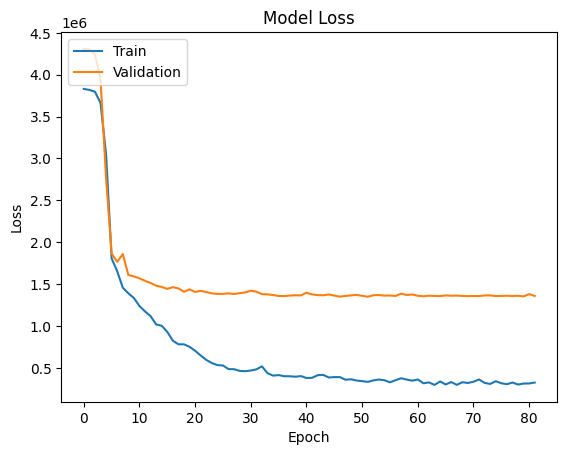

In [19]:
#load the fit-history 
with open(f"{MODELS_PATH}/MobileNetV3_Large_1/history", "rb") as file_pi:
    history = pickle.load(file_pi)

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig(f"{MODELS_PATH}/MobileNetV3_Large_1/loss.png")
plt.show()
plt.close()

### CNN RF

#### MobileNetV3Large + Random Forrest

In [20]:
MobileNet_CNN = keras.models.load_model(f"{MODELS_PATH}/MobileNetV3_Large_1/model")

In [21]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "MobileNetV3_Large_RF_1"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    MobileNet_CNN, # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    train2_images,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU


9/9 [==============================] - 11s 847ms/step
Saving Model...
5/5 [==============================] - 4s 865ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-24 09:36:35.974806', 'R2': 0.8024471865457328, 'MAE': 671255.0625, 'Percentage Error': 15.981855375680102, 'MSE': 952771858069.375, 'Feature Importances': {'image_predictions': 0.029521300671814472, 'postal_code': 0.08240203412469567, 'type': 0.0, 'size': 0.6228312266221692, 'basement_size': 0.0, 'rooms': 0.008953514720596849, 'year_built': 0.03636944500682485, 'year_rebuilt': 0.053863568557548154, 'energy_label': 0.010503486896760283, 'postal_avg_sqm_price': 0.11369033184019188, 'lat': 0.017422365513763347, 'lng': 0.024442726045635254}}

Median Evaluation:
{'R2': 0.8167331440759821, 'MAE': 644872.6875, 'Percentage Error': 15.384344816548316, 'MSE': 883872518888.125}
Feauter Importance...
{'image_predictions': 0.029521300671814472, 'postal_code': 0.08240203412469567, 'type': 0.0, 'size': 0.62283122662216

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


#### VGG16 + Random Forrest

In [38]:
VGG_16_CNN_Img_model = keras.models.load_model(f"{MODELS_PATH}/VGG16/model")

In [23]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "VGG16_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    VGG_16_CNN_Img_model, 
    train2_images_448,
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 229s 25s/step
Saving Model...
5/5 [==============================] - 121s 23s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-24 09:42:39.935545', 'R2': 0.8092763463090193, 'MAE': 655946.125, 'Percentage Error': 15.534382738341163, 'MSE': 919835697237.5, 'Feature Importances': {'image_predictions': 0.04075140657534039, 'postal_code': 0.06404863078457773, 'type': 0.0, 'size': 0.6318417967335823, 'basement_size': 0.0, 'rooms': 0.007986606429831835, 'year_built': 0.04288937099924113, 'year_rebuilt': 0.0397144033445683, 'energy_label': 0.009300631583421958, 'postal_avg_sqm_price': 0.12326877177509926, 'lat': 0.01788321908631034, 'lng': 0.02231516268802677}}

Median Evaluation:
{'R2': 0.8068028789465412, 'MAE': 658335.3125, 'Percentage Error': 15.548370290492839, 'MSE': 931764912790.625}
Feauter Importance...
{'image_predictions': 0.04075140657534039, 'postal_code': 0.06404863078457773, 'type': 0.0, 'size': 0.631841796733

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


#### EfficientNet + Random Forret

In [39]:
EfficientNetB3_CNN_Img_model = keras.models.load_model(f"{MODELS_PATH}/EfficientNetB3/model")

In [40]:
from models import CNN_RF_model
TYPE = 'CNN_RF'
MODEL_NAME: str = "EfficientNetB3_RF"
FUNCTION: object = CNN_RF_model
ARGS: tuple = (
    EfficientNetB3_CNN_Img_model, # keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    train2_images_448,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 102s 10s/step
Saving Model...
5/5 [==============================] - 49s 10s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-24 10:30:20.090245', 'R2': 0.8189143793412997, 'MAE': 644982.375, 'Percentage Error': 15.3120807833682, 'MSE': 873352701223.75, 'Feature Importances': {'image_predictions': 0.02057554770838023, 'postal_code': 0.060683421053048074, 'type': 0.0, 'size': 0.6466242393193626, 'basement_size': 0.0, 'rooms': 0.008106740399842364, 'year_built': 0.03289206354714701, 'year_rebuilt': 0.0492362257333725, 'energy_label': 0.007050059717095081, 'postal_avg_sqm_price': 0.13361597661123262, 'lat': 0.01825275675524909, 'lng': 0.022962969155270303}}

Median Evaluation:
{'R2': 0.8156752517691555, 'MAE': 640579.1875, 'Percentage Error': 15.122464301980237, 'MSE': 888974597675.0}
Feauter Importance...
{'image_predictions': 0.02057554770838023, 'postal_code': 0.060683421053048074, 'type': 0.0, 'size': 0.6466242393193

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Done!


### CNN + AE + RF

In [41]:
from models import autoEncoder
try: 
  AE_224 = pickle.load(open(f"{MODELS_PATH}/AE_224", "rb"))
except:  
  AE_224 = autoEncoder(train1_images, latent_dim=128)
  pickle.dump(AE_224, open(f"{MODELS_PATH}/AE_224", "wb"))

In [27]:
try: 
  AE_448 = pickle.load(open(f"{MODELS_PATH}/AE_448", "rb"))

except:
  AE_448 = autoEncoder(train1_images_448, latent_dim=128)
  pickle.dump(AE_448, open(f"{MODELS_PATH}/AE_448", "wb"))

#### MobileNet_AE_RF

In [28]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "MobileNetV3_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    MobileNet_CNN, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_224, #Or none for training it from scratch
    train2_images,
    train2_features,
    train2_prices,
)
train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 8s 860ms/step
Saving Model...
5/5 [==============================] - 4s 822ms/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-24 10:03:58.267272', 'R2': 0.8134075929188453, 'MAE': 650221.5, 'Percentage Error': 15.535300640049204, 'MSE': 899911225195.0, 'Feature Importances': {'image_predictions': 0.026601862002836794, 'reconstruction_error': 0.023202180068227888, 'postal_code': 0.06240135181576216, 'type': 0.0, 'size': 0.6384427755693618, 'basement_size': 0.0, 'rooms': 0.009059526108560582, 'year_built': 0.02725177050024651, 'year_rebuilt': 0.038377657566003386, 'energy_label': 0.007523993665372348, 'postal_avg_sqm_price': 0.13109038280180077, 'lat': 0.0135048125148473, 'lng': 0.022543687386980635}}

Median Evaluation:
{'R2': 0.8104093489193249, 'MAE': 650221.5, 'Percentage Error': 15.535300640049204, 'MSE': 914371371099.375}
Feauter Importance...
{'image_predictions': 0.026601862002836794, 'reconstruction_error': 0.

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 2s 454ms/step
[ 41  30  54 136  18 124  69 147 107  27]
[ 53  50   2  43 135  93 142  13 123  96]
1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 58ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 55ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 52ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 62ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 53ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 54ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 69ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 96ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 90ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


#### VGG16_AE_RF

In [29]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "VGG16_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    VGG_16_CNN_Img_model, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_448, #Or none for training it from scratch
    train2_images_448,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 232s 25s/step
Saving Model...
5/5 [==============================] - 117s 24s/step
Evaluating Model...


/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Model Evaluation:
{'Timestamp': '2024-05-24 10:12:44.722780', 'R2': 0.8087690871412831, 'MAE': 648057.6875, 'Percentage Error': 15.413254208961819, 'MSE': 922282143083.125, 'Feature Importances': {'image_predictions': 0.03873901824415874, 'reconstruction_error': 0.02139770368619003, 'postal_code': 0.058812208209231914, 'type': 0.0, 'size': 0.6355759177399273, 'basement_size': 0.0, 'rooms': 0.006129995384232717, 'year_built': 0.02600472751867115, 'year_rebuilt': 0.048667902801481984, 'energy_label': 0.006180223942825581, 'postal_avg_sqm_price': 0.12261925963678319, 'lat': 0.014505971796203101, 'lng': 0.02136707104029444}}

Median Evaluation:
{'R2': 0.8126657697561032, 'MAE': 648704.53125, 'Percentage Error': 15.49226355461655, 'MSE': 903488943075.9375}
Feauter Importance...
{'image_predictions': 0.03873901824415874, 'reconstruction_error': 0.02139770368619003, 'postal_code': 0.058812208209231914, 'type': 0.0, 'size': 0.6355759177399273, 'basement_size': 0.0, 'rooms': 0.0061299953842327

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 105ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 97ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 121ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 106ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 94ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 113ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 129ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 133ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 150ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


#### EfficientNet + RF + Features

In [30]:
from models import CNN_AE_RF_model
#img_model =  keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
TYPE = 'CNN_AE_RF'
MODEL_NAME: str = "EfficientNetB3_AE_RF"
FUNCTION: object = CNN_AE_RF_model
ARGS: tuple = (
    EfficientNetB3_CNN_Img_model, #keras.models.load_model(f"{MODELS_PATH}/MobileNetV2/model")
    AE_448, #Or none for training it from scratch
    train2_images_448,
    train2_features,
    train2_prices,
)

train_save_model(FUNCTION, ARGS, test_images_448, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

Setting CPU
9/9 [==============================] - 90s 10s/step
Saving Model...
5/5 [==============================] - 49s 10s/step
Evaluating Model...

Model Evaluation:
{'Timestamp': '2024-05-24 10:18:07.573753', 'R2': 0.8062549288488805, 'MAE': 661055.75, 'Percentage Error': 15.958476177371569, 'MSE': 934407605767.5, 'Feature Importances': {'image_predictions': 0.01767831607144094, 'reconstruction_error': 0.03310528256682961, 'postal_code': 0.07786182604340891, 'type': 0.0, 'size': 0.6334121681109692, 'basement_size': 0.0, 'rooms': 0.008427679789857194, 'year_built': 0.026812015743029372, 'year_rebuilt': 0.04995841648578728, 'energy_label': 0.006303278825791749, 'postal_avg_sqm_price': 0.10970762540896001, 'lat': 0.01447383605865671, 'lng': 0.02225955489526913}}

Median Evaluation:
{'R2': 0.8153741473128682, 'MAE': 645540.25, 'Percentage Error': 15.47439580959514, 'MSE': 890426785812.8125}
Feauter Importance...
{'image_predictions': 0.01767831607144094, 'reconstruction_error': 0.033

/usr/local/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



Saving Feature Importance

Saving Reconstructions
5/5 [==============================] - 8s 2s/step
[ 65  30  41 151  18  54 118  76 122  69]
[ 53  50   2 102 140 135  43 123 100  13]
1/1 [==============================] - 0s 226ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 103ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 92ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 108ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 115ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 117ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 114ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 105ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 98ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 99ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 101ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 100ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Done!


# Other Things

### N-CNN

In [33]:
from models import N_CNN_RF_model
from keras.applications import MobileNetV3Small
TYPE = 'CNN_RF'
MODEL_NAME: str = "N_CNN_MobileNetV2_RF"
FUNCTION: object = N_CNN_RF_model
ARGS: tuple = (
    4,
    MobileNetV3Small,
    np.concatenate((train1_images, train2_images), axis=0),
    pd.concat((train1_features, train2_features), axis=0),

    np.concatenate((train1_prices, train2_prices), axis=0),
)
#train_save_model(FUNCTION, ARGS, test_images, test_features,  test_prices, f"{MODELS_PATH}/{MODEL_NAME}", USE_GPU, TYPE)

## Sample of Best and Worst Predictions from CNN

5/5 [==============================] - 8s 950ms/step


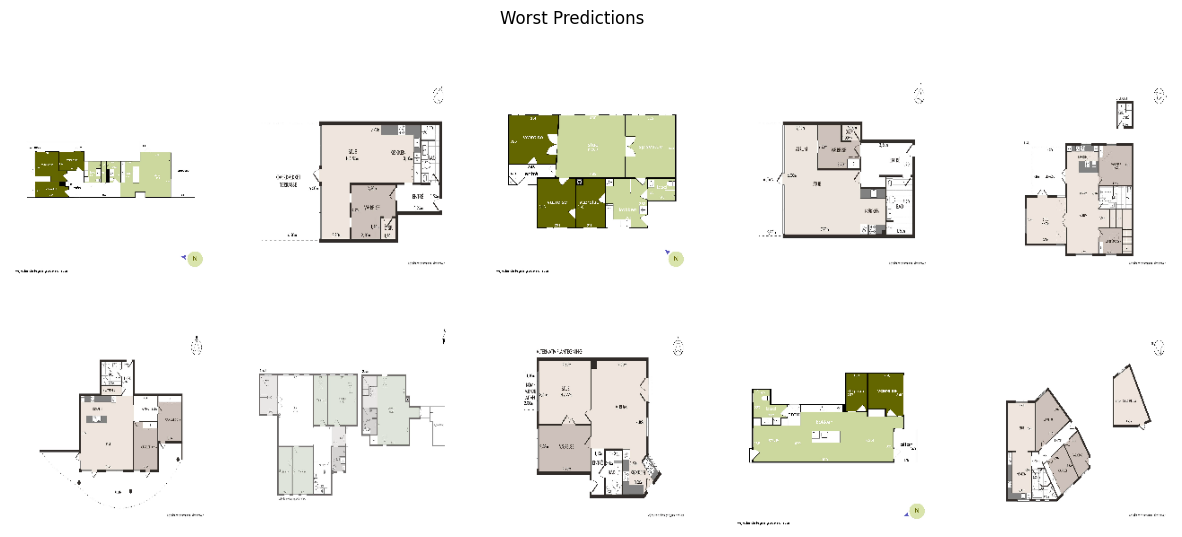

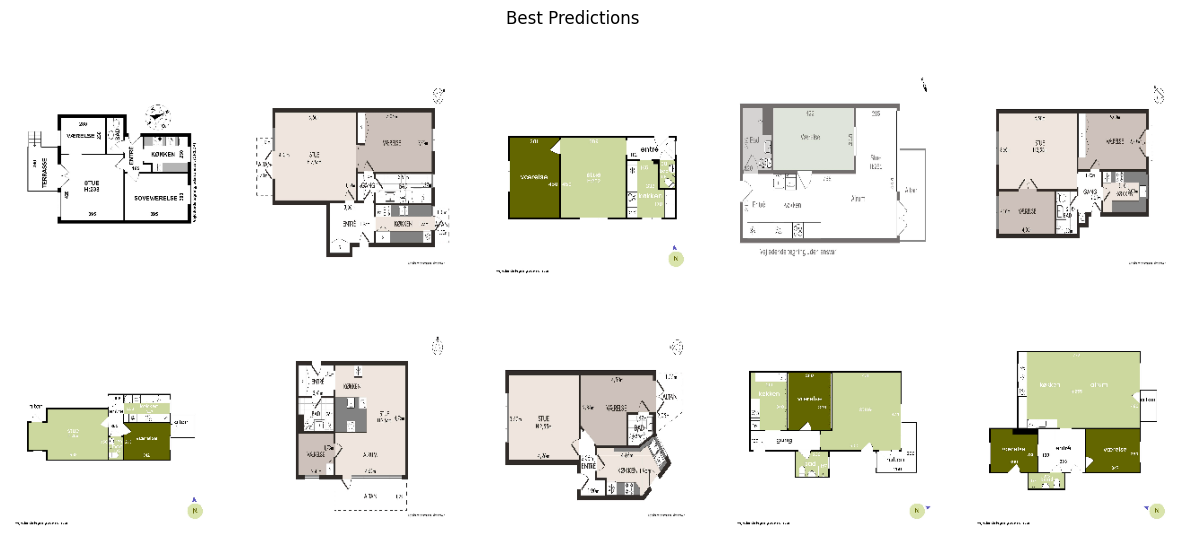

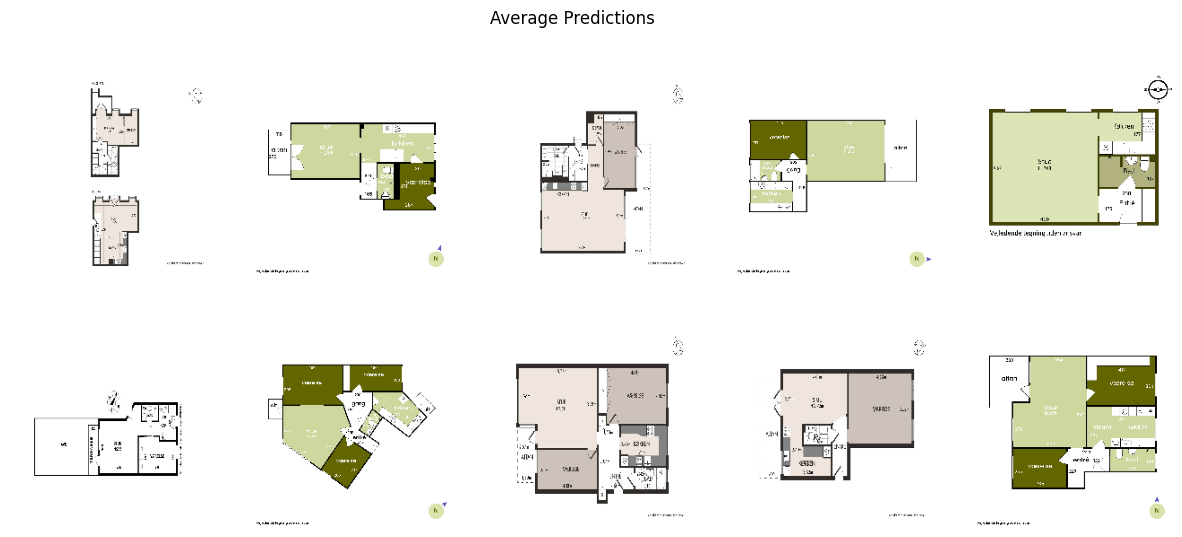

In [34]:
"""
This cell is used for showcasing 10 random floorplans from the worst and best predictoins (Based off residuals)
"""
MB_model = keras.models.load_model(f"{MODELS_PATH}/MobileNetV3_Large_1/model")
test_predictions = MB_model.predict(test_images)
test_prices = test_prices
residuals = np.abs(test_prices - test_predictions.flatten())
idx = np.argsort(residuals)
worst_idx = idx[-30:]
best_idx = idx[:30]
average_idx = idx[30:-30]
#take 10 randomm samples from worst and best 
worst_idx = np.random.choice(worst_idx, 10, replace=False)
best_idx = np.random.choice(best_idx, 10, replace=False)
average_idx = np.random.choice(average_idx, 10, replace=False)

# Load the images
worst_images = test_images[worst_idx]
best_images = test_images[best_idx]
average_images = test_images[average_idx]

# Load the prices
worst_prices = test_prices[worst_idx]
worst_predictions = test_predictions[worst_idx]
worst_residuals = residuals[worst_idx]

# Load the predictions
best_predictions = test_predictions[best_idx]
best_prices = test_prices[best_idx]
best_residuals = residuals[best_idx]

# Load the prices
average_prices = test_prices[average_idx]
average_predictions = test_predictions[average_idx]
average_residuals = residuals[average_idx]

#Plot the images in 2x5 grid 
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Worst Predictions")
for i, ax in enumerate(axs.flatten()):
    ax.imshow(worst_images[i])
    #ax.set_title(f"Price: {worst_prices[i]}\nPrediction: {worst_predictions[i]}\nResidual: {worst_residuals[i]}")
    ax.axis("off") 
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Best Predictions")
for i, ax in enumerate(axs.flatten()):
    ax.imshow(best_images[i])
    #ax.set_title(f"Price: {best_prices[i]}\nPrediction: {best_predictions[i]}\nResidual: {best_residuals[i]}")
    ax.axis("off") 
plt.show()

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Average Predictions")
for i, ax in enumerate(axs.flatten()):
    ax.imshow(average_images[i])
    #ax.set_title(f"Price: {average_prices[i]}\nPrediction: {average_predictions[i]}\nResidual: {average_residuals[i]}")
    ax.axis("off")
plt.show()

# Other Features Based Modesls

In [35]:
from models import XGB, SVC, neural_network 
XGB_model, history = XGB(train2_features, train2_prices, test_features, test_prices)
XGB_predictions = XGB_model.predict(test_features)
r2, mae, percentage_error, mse = regression_stats(test_prices, XGB_predictions)
print(f"XGB R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")

XGB R2: 0.7832011986738399, MAE: 677944.74765625, Percentage Error: 16.052277867078033, MSE: 1045592786834.984


In [36]:
NN_model, NN_history = neural_network(train2_features, train2_prices, test_features, test_prices)
NN_predictions = NN_model.predict(test_features)
r2, mae, percentage_error, mse = regression_stats(test_prices, NN_predictions)
print(f"NN R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")

num_features 11
Epoch 1/300
5/5 [==============================] - 4s 127ms/step - loss: 3744394.7500 - mean_absolute_error: 3744394.7500 - val_loss: 4034205.5000 - val_mean_absolute_error: 4034205.5000
Epoch 2/300
5/5 [==============================] - 0s 21ms/step - loss: 3744301.2500 - mean_absolute_error: 3744301.2500 - val_loss: 4034097.5000 - val_mean_absolute_error: 4034097.5000
Epoch 3/300
5/5 [==============================] - 0s 16ms/step - loss: 3744187.2500 - mean_absolute_error: 3744187.2500 - val_loss: 4033956.7500 - val_mean_absolute_error: 4033956.7500
Epoch 4/300
5/5 [==============================] - 0s 15ms/step - loss: 3744032.5000 - mean_absolute_error: 3744032.5000 - val_loss: 4033770.0000 - val_mean_absolute_error: 4033770.0000
Epoch 5/300
5/5 [==============================] - 0s 16ms/step - loss: 3743835.2500 - mean_absolute_error: 3743835.2500 - val_loss: 4033525.5000 - val_mean_absolute_error: 4033525.5000
Epoch 6/300
5/5 [==============================] - 0s

In [37]:
SVC_model = SVC(train2_features, train2_prices, test_features, test_prices)

SVC_predictions = SVC_model.predict(test_features)

r2, mae, percentage_error, mse = regression_stats(test_prices, SVC_predictions)
print(f"SVC R2: {r2}, MAE: {mae}, Percentage Error: {percentage_error}, MSE: {mse}")

SVC R2: -0.22403028322216034, MAE: 1658456.25, Percentage Error: 36.8540820367793, MSE: 5903340918750.0
